<a href="https://colab.research.google.com/github/IvanKatorgin/Deep-Learning/blob/main/Deep_Learning_%D0%B4%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Курс "Deep Learning". Домашнее задание 9. Механизм внимания. Каторгин И.П.

## Задание
Решить задачу перевода с помощью механизма внимания

1. Возьмите англо-русскую пару фраз (https://www.manythings.org/anki/)
2. Обучите на них seq2seq with attention

a. На основе скалярного произведения

b. На основе MLP
3. Оцените качество

In [26]:
# загрузим библиотеки
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np, pandas as pd
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [3]:
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Возьмите англо-русскую пару фраз

In [4]:
# загрузим файл
!wget https://www.manythings.org/anki/rus-eng.zip
!unzip rus-eng.zip

--2025-06-22 04:38:51--  https://www.manythings.org/anki/rus-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16986904 (16M) [application/zip]
Saving to: ‘rus-eng.zip’

rus-eng.zip         100%[===================>]  16.20M  21.7MB/s    in 0.7s    

2025-06-22 04:38:56 (21.7 MB/s) - ‘rus-eng.zip’ saved [16986904/16986904]

Archive:  rus-eng.zip
  inflating: rus.txt                 
  inflating: _about.txt              


In [5]:
# загрузим файл
with open('rus.txt', 'r', encoding='utf-8') as f:
  lines = f.read().strip().split('\n')

In [6]:
lines[:10]

['Go.\tМарш!\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1159202 (shanghainese)',
 'Go.\tИди.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #5898247 (marafon)',
 'Go.\tИдите.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #5898250 (marafon)',
 'Hi.\tЗдравствуйте.\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #402127 (odexed)',
 'Hi.\tПривет!\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #466968 (katjka)',
 'Hi.\tХай.\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #467233 (timsa)',
 'Hi.\tЗдрасте.\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #3803577 (marafon)',
 'Hi.\tЗдоро́во!\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #3854188 (marafon)',
 'Hi.\tПриветик!\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #7234283 (marafon)',
 'Run!\tБеги!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #1569978 (Biga)']

In [7]:
# загрузим файл
!tail rus.txt

I've heard that you should never date anyone who is less than half your age plus seven. Tom is now 30 years old and Mary is 17. How many years will Tom need to wait until he can start dating Mary?	Я слышал, что никогда не следует встречаться с кем-то вдвое младше вас плюс семь лет. Тому 30 лет, a Мэри 17. Сколько лет Тому нужно ждать до тех пор, пока он сможет начать встречаться с Мэри?	CC-BY 2.0 (France) Attribution: tatoeba.org #10068197 (CK) & #10644473 (notenoughsun)
I do have one final ask of you as your president, the same thing I asked when you took a chance on me eight years ago. I'm asking you to believe, not in my ability to bring about change but in yours.	У меня же, как у вашего президента, есть к вам последняя просьба. Та же самая, что и восемь лет назад, когда вы оказали мне своё доверие. Я прошу вас верить, но не в мои способности добиться перемен, а в ваши.	CC-BY 2.0 (France) Attribution: tatoeba.org #5762723 (BHO) & #6390123 (odexed)
In today's world, we have to equip 

Переименуем файл rus в eng-rus и приведем словарь к обучаемому виду

In [8]:
# приведем словарь к обучаемому виду
sep = 'CC-BY'
with open('eng-rus.txt') as file:
    for line in file:
        print(line.split(sep, 1)[0])

Выходные данные были обрезаны до нескольких последних строк (5000).
I wasn't surprised when Tom told me Mary didn't want to do that.	Я не удивился, когда Том сказал мне, что Мэри не хочет это делать.	
I wish I could've spent more time with my father before he died.	Как бы я хотел провести больше времени со своим отцом перед его смертью.	
I wish that I hadn't told Tom that I'd go to Australia with him.	Зря я сказал Тому, что поеду с ним в Австралию.	
I wonder how much further I could've gone if I'd actually tried.	Интересно, насколько дальше я мог бы зайти, если бы правда старался.	
I wonder if Tom knows why Mary was absent from school yesterday.	Интересно, знает ли Том, почему Мэри вчера отсутствовала в школе.	
I would rather remain single than live an unhappy life with him.	Я лучше останусь одна, чем буду всю жизнь несчастлива с ним.	
I would've told you before, but I didn't think you'd understand.	Я бы тебе раньше сказал, но я не думал, что ты поймешь.	
I'd like to find out how Tom i

## Обучите seq2seq with attention на основе скалярного произведения. Оцените качество

In [28]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [29]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = s.lower()
    s = re.sub('[.!?]','',s)
#    s = re.sub(r"([.!?])", r" \1", s)
#    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [30]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')
    lines = [i.split('\tCC-BY', 1)[0] for i in lines]

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [31]:
MAX_LENGTH = 30

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [32]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'rus', True)
print(random.choice(pairs))

Reading lines...
Read 519900 sentence pairs
Trimmed to 5319 sentence pairs
Counting words...
Counted words:
rus 4890
eng 2475
['она говорит не только по-немецки и по-французски, но и по-англииски', 'she speaks not only german and french, but english as well']


The Encoder
-----------





In [33]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

The Decoder
-----------




In [34]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, max_length=MAX_LENGTH, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.max_length = max_length
        self.dropout_p = dropout_p

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attn = nn.Linear(self.hidden_size, self.hidden_size)  # Проекция для dot-product
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        # Calculate attention weights
        attn_weights = F.softmax(
            torch.matmul(self.attn(hidden)[0], encoder_outputs.t()) / (self.hidden_size ** 0.5),
            dim=1
        )

        # Apply attention to encoder outputs
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights.squeeze(0)

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [35]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [36]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder,
          encoder_optimizer, decoder_optimizer, criterion,
          max_length=MAX_LENGTH, just_loss=False):
    """
    just_loss: Если True, только вычисляет loss без обновления весов
    """
    encoder_hidden = encoder.initHidden()

    if not just_loss:
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    loss = 0

    # Прямой проход через encoder
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    # Прямой проход через decoder
    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    for di in range(target_length):
        decoder_output, decoder_hidden, _ = decoder(
            decoder_input, decoder_hidden, encoder_outputs)

        loss += criterion(decoder_output, target_tensor[di])

        if use_teacher_forcing:
            decoder_input = target_tensor[di]
        else:
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()
            if decoder_input.item() == EOS_token:
                break

    if not just_loss:
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()

    return loss.item() / target_length

In [37]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [38]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [39]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [40]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length, device=device)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)

            # Store attention weights (only for the actual input length)
            if di < max_length:
                decoder_attentions[di, :input_length] = decoder_attention[:input_length]

            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [41]:
# добавим функцию для расчета BLEU
def calculate_bleu(encoder, decoder, pairs, n=100):
    references = []
    hypotheses = []
    smoothie = SmoothingFunction().method4

    for i in range(min(n, len(pairs))):
        pair = random.choice(pairs)
        input_sentence = pair[0]
        target_sentence = pair[1]

        # Получаем предсказание модели
        output_words, _ = evaluate(encoder, decoder, input_sentence)
        output_sentence = ' '.join(output_words[:-1])  # Убираем <EOS>

        # Токенизируем предложения
        ref_tokens = target_sentence.split()
        hyp_tokens = output_sentence.split()

        references.append([ref_tokens])
        hypotheses.append(hyp_tokens)

    # Вычисляем BLEU-1, BLEU-2, BLEU-3, BLEU-4
    bleu1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0), smoothing_function=smoothie) # Учитывает только точность отдельных слов (1-граммы)
    bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie) # Учитывает пары последовательных слов
    bleu3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie) # Учитывает тройки последовательных слов
    bleu4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie) # Учитывает четверки последовательных слов

    return bleu1, bleu2, bleu3, bleu4

In [42]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [43]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

5m 2s (- 70m 36s) (5000 6%) 3.2526
10m 9s (- 66m 1s) (10000 13%) 2.7263
15m 19s (- 61m 18s) (15000 20%) 2.3256
20m 39s (- 56m 48s) (20000 26%) 1.8792
25m 52s (- 51m 44s) (25000 33%) 1.5422
31m 16s (- 46m 55s) (30000 40%) 1.2448
36m 53s (- 42m 9s) (35000 46%) 1.0238
42m 20s (- 37m 2s) (40000 53%) 0.8319
47m 44s (- 31m 49s) (45000 60%) 0.6887
53m 12s (- 26m 36s) (50000 66%) 0.5274
58m 34s (- 21m 17s) (55000 73%) 0.4236
63m 56s (- 15m 59s) (60000 80%) 0.3418
69m 12s (- 10m 38s) (65000 86%) 0.2635
74m 26s (- 5m 19s) (70000 93%) 0.2045
79m 38s (- 0m 0s) (75000 100%) 0.1671


In [44]:
bleu1, bleu2, bleu3, bleu4 = calculate_bleu(encoder1, attn_decoder1, pairs, n=500)
print(f"BLEU-1: {bleu1:.4f}")
print(f"BLEU-2: {bleu2:.4f}")
print(f"BLEU-3: {bleu3:.4f}")
print(f"BLEU-4: {bleu4:.4f}")

BLEU-1: 0.9676
BLEU-2: 0.9571
BLEU-3: 0.9481
BLEU-4: 0.9315


In [45]:
evaluateRandomly(encoder1, attn_decoder1)

> мне грустно из-за этого
= i am feeling sad about it
< i am feeling sad about it <EOS>

> ее там нет
= she isn't there
< she isn't there <EOS>

> мы недалеко
= we aren't going far
< we aren't going far <EOS>

> простите, что заставил вас так долго ждать
= i am sorry to have kept you waiting so long
< i am sorry to have kept you waiting so long <EOS>

> высаживаю фасоль в своем саду
= i am planting beans in my garden
< i am planting beans in my garden <EOS>

> он всегда дарит подарки своеи жене
= he is always giving presents to his wife
< he is always giving presents to his wife <EOS>

> он все еще стоит
= he is still standing
< he is still standing <EOS>

> я учусь на переводчика
= i am studying to be a translator or interpreter
< i am studying to be a translator or interpreter <EOS>

> с нетерпением жду встречи с вами
= i am looking forward to seeing you
< i am looking forward to seeing you <EOS>

> она очень умна
= she is very intelligent
< she is very clever <EOS>



<Figure size 640x480 with 0 Axes>

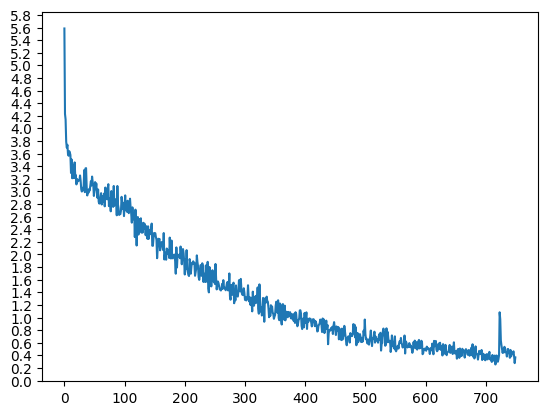

<Figure size 640x480 with 0 Axes>

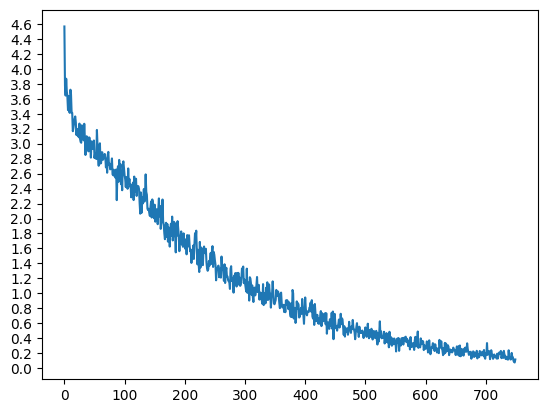

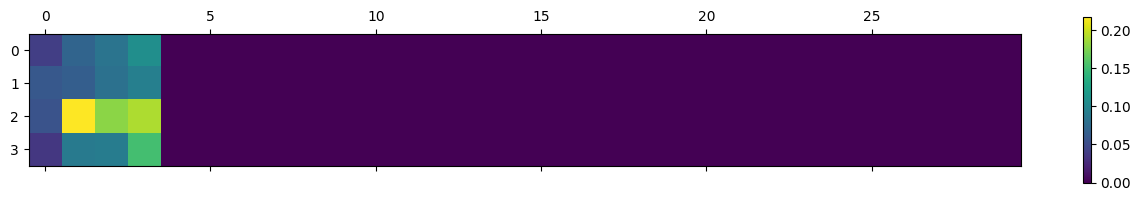

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Визуализация внимания
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "она говорит по-китаиски")

# Отображение матрицы внимания
plt.matshow(attentions.numpy())
plt.colorbar()
plt.show()

input = она говорит по-китаиски
output = she speaks chinese <EOS>


/tmp/ipython-input-47-1853501292.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipython-input-47-1853501292.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


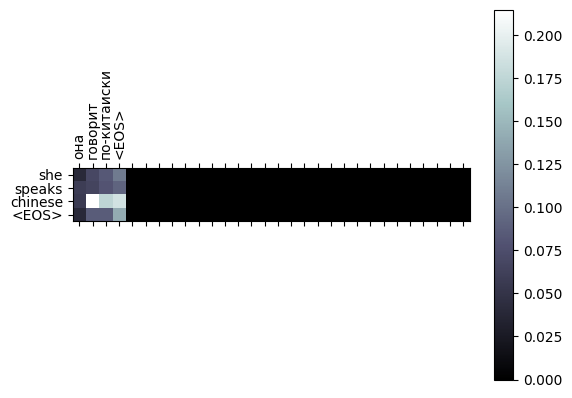

input = их разделяет большое расстояние
output = they are separated by a great distance <EOS>


/tmp/ipython-input-47-1853501292.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipython-input-47-1853501292.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


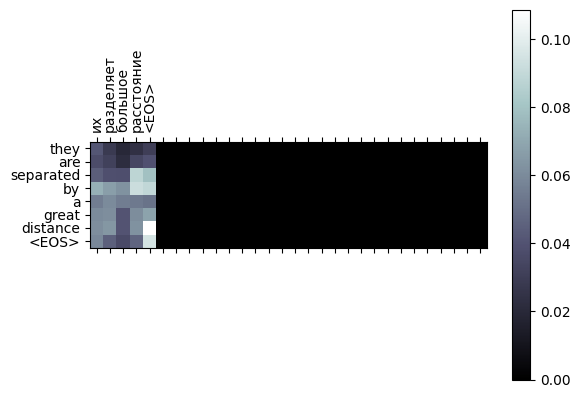

input = тебе в эту комнату нельзя
output = you aren't allowed in this room <EOS>


/tmp/ipython-input-47-1853501292.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipython-input-47-1853501292.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


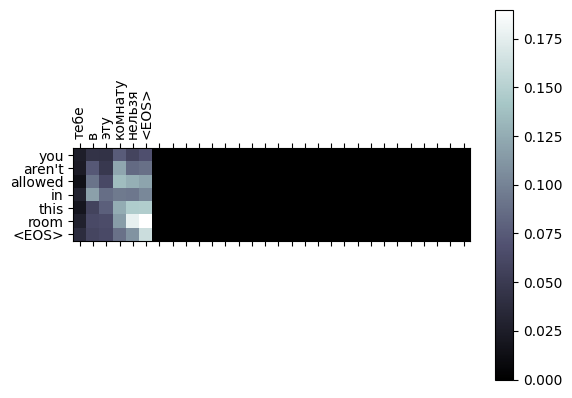

input = она видела их рядом с твоим магазином
output = she saw them to your store <EOS>


/tmp/ipython-input-47-1853501292.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipython-input-47-1853501292.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


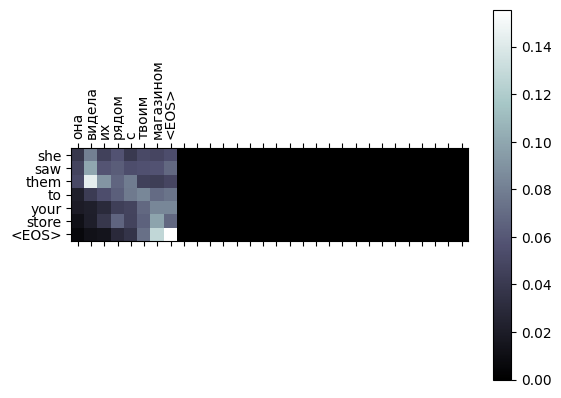

In [47]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("она говорит по-китаиски")

evaluateAndShowAttention("их разделяет большое расстояние")

evaluateAndShowAttention("тебе в эту комнату нельзя")

evaluateAndShowAttention("она видела их рядом с твоим магазином")

Качество обучения показывает хорошие значения и предсказанный перевод полностью совпадает со словарным

Попробуем улучшить модель с помощью Multi-Head Attention

In [98]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [99]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = s.lower()
    s = re.sub('[.!?]','',s)
#    s = re.sub(r"([.!?])", r" \1", s)
#    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [100]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')
    lines = [i.split('\tCC-BY', 1)[0] for i in lines]

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [101]:
MAX_LENGTH = 30

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [102]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'rus', True)
print(random.choice(pairs))

Reading lines...
Read 519900 sentence pairs
Trimmed to 5319 sentence pairs
Counting words...
Counted words:
rus 4890
eng 2475
['не ожидала увидеть вас здесь, в этои гостинице', 'i am surprised to see you here in this hotel']


The Encoder
-----------





In [103]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

Добавляем Multi-head attention

In [104]:
class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_size, num_heads=8):
        super().__init__()
        assert hidden_size % num_heads == 0
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads

        # Проекционные слои для Q, K, V
        self.query = nn.Linear(hidden_size, hidden_size)
        self.key = nn.Linear(hidden_size, hidden_size)
        self.value = nn.Linear(hidden_size, hidden_size)

        self.out = nn.Linear(hidden_size, hidden_size)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        # Линейные проекции и разделение на головы
        Q = self.query(query).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.key(key).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.value(value).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)

        # Масштабированное скалярное произведение
        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        attn_weights = F.softmax(scores, dim=-1)
        output = torch.matmul(attn_weights, V)

        # Конкатенация голов и финальная проекция
        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.hidden_size)
        return self.out(output), attn_weights

The Decoder
-----------




In [105]:
# немного модифицируем AttnDecoderRNN
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, max_length=MAX_LENGTH, dropout_p=0.1, num_heads=8):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.max_length = max_length
        self.dropout_p = dropout_p
        self.num_heads = num_heads  # Сохраняем количество голов

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = MultiHeadAttention(hidden_size, num_heads)  # Многоголовое внимание
        self.attn_combine = nn.Linear(hidden_size * 2, hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        # Multi-Head Attention
        attn_output, attn_weights = self.attention(
            query=hidden.transpose(0, 1),  # [1,1,hidden_size]
            key=encoder_outputs.unsqueeze(0),  # [1,max_len,hidden_size]
            value=encoder_outputs.unsqueeze(0)
        )

        # Комбинирование с входом
        output = torch.cat((embedded[0], attn_output[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights.squeeze()

In [106]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [107]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder,
          encoder_optimizer, decoder_optimizer, criterion,
          max_length=MAX_LENGTH, just_loss=False):
    """
    just_loss: Если True, только вычисляет loss без обновления весов
    """
    encoder_hidden = encoder.initHidden()

    if not just_loss:
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    loss = 0

    # Прямой проход через encoder
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    # Прямой проход через decoder
    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    for di in range(target_length):
        decoder_output, decoder_hidden, _ = decoder(
            decoder_input, decoder_hidden, encoder_outputs)

        loss += criterion(decoder_output, target_tensor[di])

        if use_teacher_forcing:
            decoder_input = target_tensor[di]
        else:
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()
            if decoder_input.item() == EOS_token:
                break

    if not just_loss:
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()

    return loss.item() / target_length

In [108]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [109]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [110]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [111]:
def showAttention(input_sentence, output_words, attentions, head_num=0):
    # attentions может быть [max_len, max_len] или [num_heads, max_len, max_len]
    if len(attentions.shape) == 3:
        attentions = attentions[head_num]  # Выбираем конкретную голову

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')

    ax.set_xticklabels([''] + input_sentence.split() + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [112]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] = encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden = encoder_hidden

        decoded_words = []
        # Для Multi-Head Attention меняем размерность
        if hasattr(decoder, 'num_heads'):
            decoder_attentions = torch.zeros(decoder.num_heads, max_length, max_length, device=device)
        else:
            decoder_attentions = torch.zeros(max_length, max_length, device=device)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)

            # Сохраняем attention для Multi-Head или обычного внимания
            if hasattr(decoder, 'num_heads'):
                decoder_attentions[:, di, :input_length] = decoder_attention[:, :input_length].data
            else:
                decoder_attentions[di, :input_length] = decoder_attention[:input_length].data

            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [113]:
# добавим функцию для расчета BLEU
def calculate_bleu(encoder, decoder, pairs, n=100):
    references = []
    hypotheses = []
    smoothie = SmoothingFunction().method4

    for i in range(min(n, len(pairs))):
        pair = random.choice(pairs)
        input_sentence = pair[0]
        target_sentence = pair[1]

        # Получаем предсказание модели
        output_words, _ = evaluate(encoder, decoder, input_sentence)
        output_sentence = ' '.join(output_words[:-1])  # Убираем <EOS>

        # Токенизируем предложения
        ref_tokens = target_sentence.split()
        hyp_tokens = output_sentence.split()

        references.append([ref_tokens])
        hypotheses.append(hyp_tokens)

    # Вычисляем BLEU-1, BLEU-2, BLEU-3, BLEU-4
    bleu1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0), smoothing_function=smoothie) # Учитывает только точность отдельных слов (1-граммы)
    bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie) # Учитывает пары последовательных слов
    bleu3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie) # Учитывает тройки последовательных слов
    bleu4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie) # Учитывает четверки последовательных слов

    return bleu1, bleu2, bleu3, bleu4

In [114]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [115]:
hidden_size = 256
encoder2 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder2 = AttnDecoderRNN(hidden_size, output_lang.n_words, num_heads=8).to(device)

trainIters(encoder2, attn_decoder2, 75000, print_every=5000)

5m 32s (- 77m 31s) (5000 6%) 3.2491
11m 13s (- 72m 57s) (10000 13%) 2.7399
17m 0s (- 68m 2s) (15000 20%) 2.3083
22m 53s (- 62m 56s) (20000 26%) 1.9251
28m 46s (- 57m 32s) (25000 33%) 1.6040
34m 40s (- 52m 0s) (30000 40%) 1.2807
40m 35s (- 46m 23s) (35000 46%) 1.0717
46m 33s (- 40m 44s) (40000 53%) 0.8504
52m 30s (- 35m 0s) (45000 60%) 0.6773
58m 30s (- 29m 15s) (50000 66%) 0.5583
64m 28s (- 23m 26s) (55000 73%) 0.4476
70m 30s (- 17m 37s) (60000 80%) 0.3426
76m 37s (- 11m 47s) (65000 86%) 0.2744
82m 42s (- 5m 54s) (70000 93%) 0.1983
88m 46s (- 0m 0s) (75000 100%) 0.1601


In [116]:
bleu1, bleu2, bleu3, bleu4 = calculate_bleu(encoder2, attn_decoder2, pairs, n=500)
print(f"BLEU-1: {bleu1:.4f}")
print(f"BLEU-2: {bleu2:.4f}")
print(f"BLEU-3: {bleu3:.4f}")
print(f"BLEU-4: {bleu4:.4f}")

BLEU-1: 0.9742
BLEU-2: 0.9655
BLEU-3: 0.9565
BLEU-4: 0.9387


In [117]:
evaluateRandomly(encoder2, attn_decoder2)

> ему сегодня немного получше
= he is a shade better today
< he is a shade better today <EOS>

> вы не канадцы
= you aren't canadian
< you aren't canadian <EOS>

> ты ведь не шпион, да
= you aren't a spy, are you
< you aren't a spy, are you <EOS>

> ты же в этом не поидешь
= you aren't going dressed like that, are you
< you aren't going dressed like that, are you <EOS>

> они сегодня не придут
= they aren't coming today
< they aren't coming today <EOS>

> ты же в этом не поидешь
= you aren't going dressed like that, are you
< you aren't going dressed like that, are you <EOS>

> он в туалете
= he is in the bathroom
< he is in the bathroom <EOS>

> он примерно твоего возраста
= he is about your age
< he is about your age <EOS>

> ты такои тупои
= you are so stupid
< you are so stupid <EOS>

> она вполне довольна своеи новои работои
= she is quite satisfied with her new job
< she is pleased with his new car <EOS>



In [118]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

def visualize_attention(input_sentence, output_words, attentions, num_heads=4):
    """
    Визуализация внимания для Multi-Head Attention

    Параметры:
        input_sentence: входное предложение (строка)
        output_words: список выходных слов
        attentions: тензор внимания shape [num_heads, target_len, input_len]
        num_heads: количество голов внимания
    """
    # Подготовка данных
    input_tokens = input_sentence.split() + ['<EOS>']
    output_tokens = output_words

    # Определяем размерности
    if len(attentions.shape) == 3:
        # Multi-Head Attention
        attention_to_show = attentions[0]  # Первая голова
        all_heads = attentions[:num_heads]  # Все головы для отображения
        num_heads = min(num_heads, attentions.shape[0])
    else:
        # Обычное внимание
        attention_to_show = attentions
        all_heads = None
        num_heads = 1

    # Создаем основную фигуру
    if all_heads is not None:
        fig = plt.figure(figsize=(15, 5 + 2*(num_heads//4)))
    else:
        fig = plt.figure(figsize=(8, 6))

    # График для основной головы
    ax_main = plt.subplot2grid((3, 4), (0, 0), colspan=4, rowspan=2)
    im = ax_main.matshow(attention_to_show.cpu().numpy(), cmap='viridis')
    plt.colorbar(im, ax=ax_main)

    # Устанавливаем метки
    ax_main.set_xticks(np.arange(len(input_tokens)))
    ax_main.set_yticks(np.arange(len(output_tokens)))
    ax_main.set_xticklabels(input_tokens, rotation=90)
    ax_main.set_yticklabels(output_tokens)
    ax_main.set_title("Attention Head 1")
    ax_main.set_xlabel("Input Tokens")
    ax_main.set_ylabel("Output Tokens")

    # Графики для дополнительных голов (если есть)
    if all_heads is not None and num_heads > 1:
        ax_main.set_title(f"Main Attention Head (1 of {num_heads})")

        # Создаем подграфики для остальных голов
        for h in range(1, num_heads):
            ax = plt.subplot2grid((3, 4), (2, h-1))
            ax.matshow(all_heads[h].cpu().numpy(), cmap='viridis')
            ax.set_title(f'Head {h+1}')
            ax.set_xticks([])
            ax.set_yticks([])

    plt.tight_layout()
    plt.show()

<Figure size 640x480 with 0 Axes>

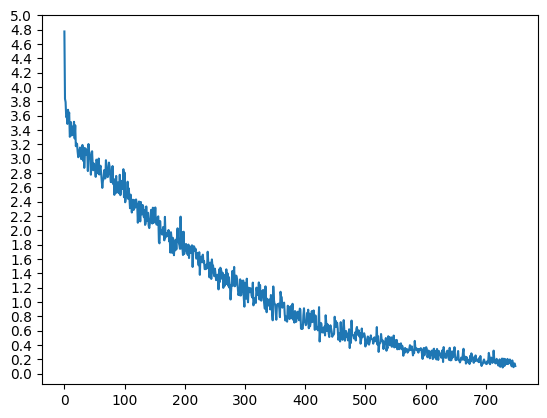

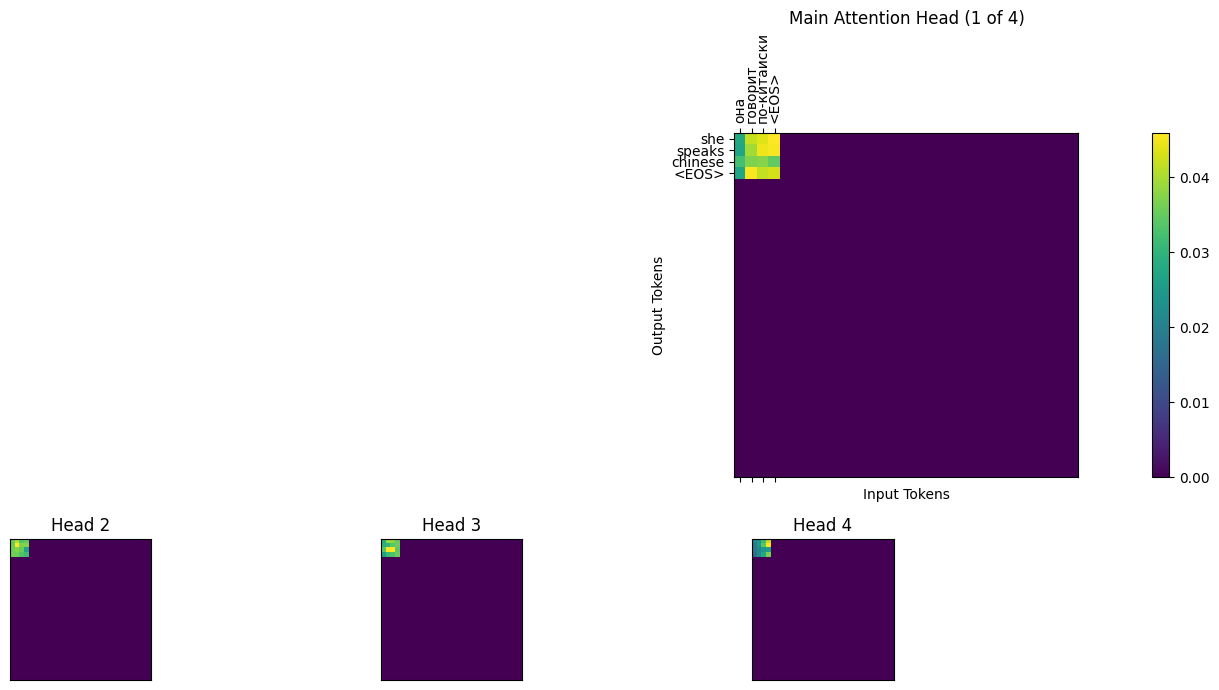

In [119]:
output_words, attentions = evaluate(encoder2, attn_decoder2, "она говорит по-китаиски")
visualize_attention("она говорит по-китаиски", output_words, attentions, num_heads=4)

In [120]:
def showAttention(input_sentence, output_words, attentions, head_num=0):
    """
    Улучшенная визуализация механизма внимания

    Параметры:
        input_sentence: входное предложение (str)
        output_words: список выходных слов
        attentions: тензор внимания (2D или 3D)
        head_num: номер головы для отображения (для Multi-Head Attention)
    """
    # Обработка Multi-Head Attention
    if len(attentions.shape) == 3:
        attentions = attentions[head_num].cpu().numpy()
    else:
        attentions = attentions.cpu().numpy()

    # Подготовка данных
    input_tokens = input_sentence.split() + ['<EOS>']
    output_tokens = output_words

    # Создание фигуры
    fig, ax = plt.subplots(figsize=(10, 8))

    # Визуализация матрицы внимания
    im = ax.imshow(attentions[:len(output_tokens), :len(input_tokens)],
                  cmap='viridis', aspect='auto')

    # Настройка осей
    ax.set_xticks(np.arange(len(input_tokens)))
    ax.set_yticks(np.arange(len(output_tokens)))
    ax.set_xticklabels(input_tokens, rotation=45, ha='right')
    ax.set_yticklabels(output_tokens)

    # Добавление цветовой шкалы
    plt.colorbar(im, ax=ax)

    # Заголовок
    if len(attentions.shape) == 3:
        ax.set_title(f'Attention Head {head_num+1}')
    else:
        ax.set_title('Attention Weights')

    plt.tight_layout()
    plt.show()

def evaluateAndShowAttention(input_sentence, head_num=0):
    output_words, attentions = evaluate(encoder2, attn_decoder2, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions, head_num)

input = она говорит по-китаиски
output = she speaks chinese <EOS>


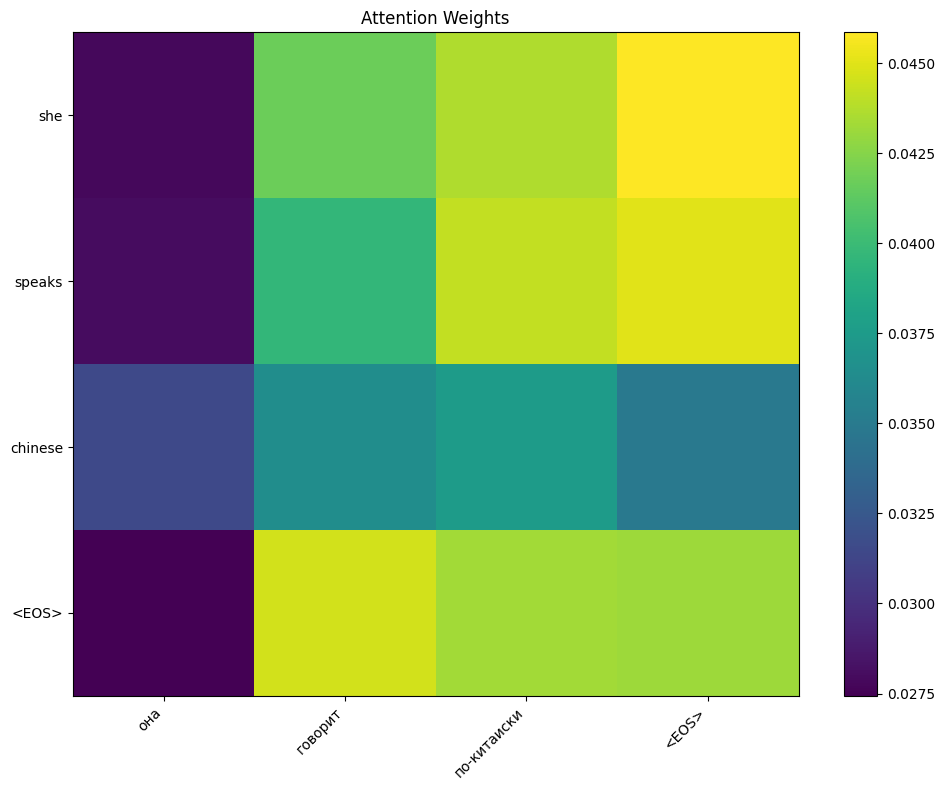

input = их разделяет большое расстояние
output = they are separated by a great distance <EOS>


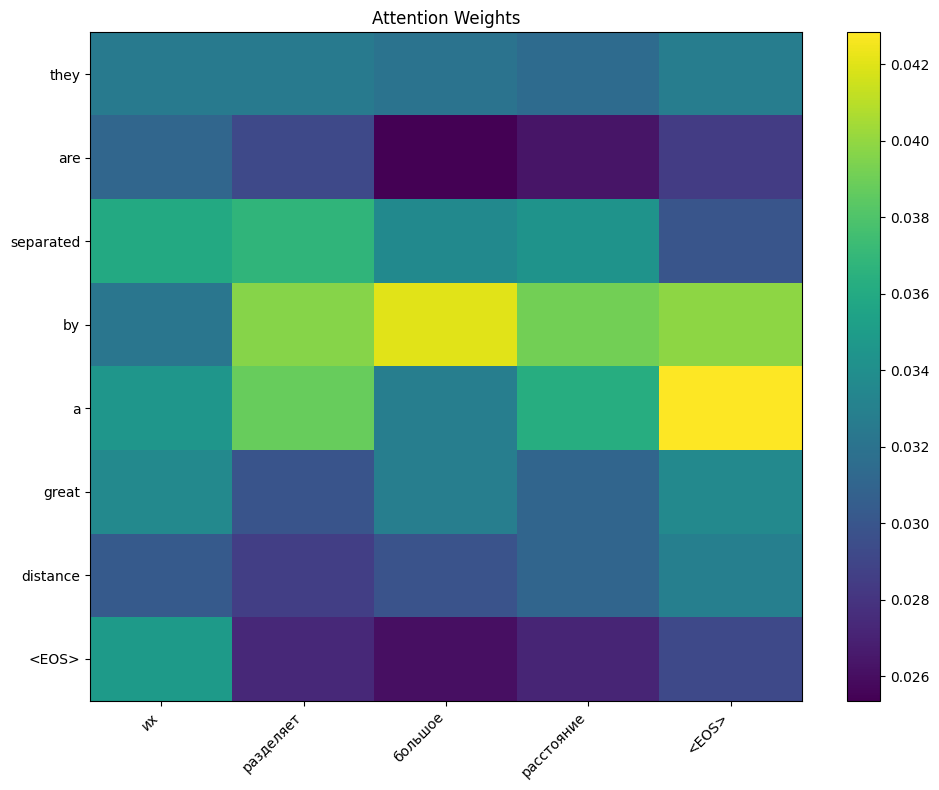

input = тебе в эту комнату нельзя
output = you aren't allowed to go into that room <EOS>


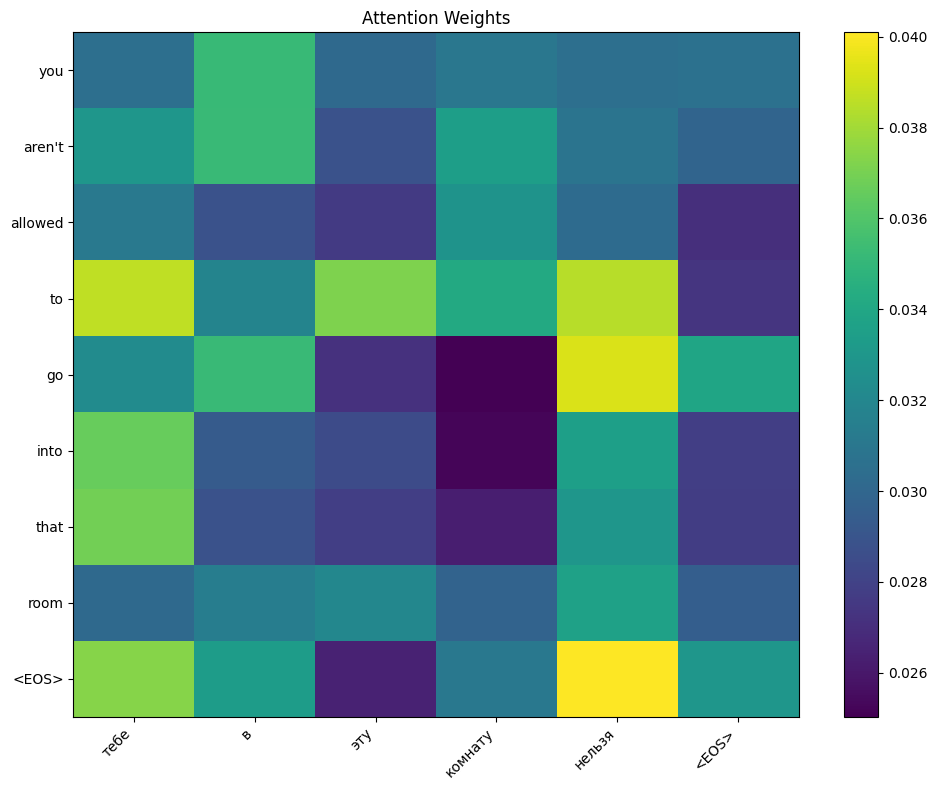

input = она видела их рядом с твоим магазином
output = she saw them next to your store <EOS>


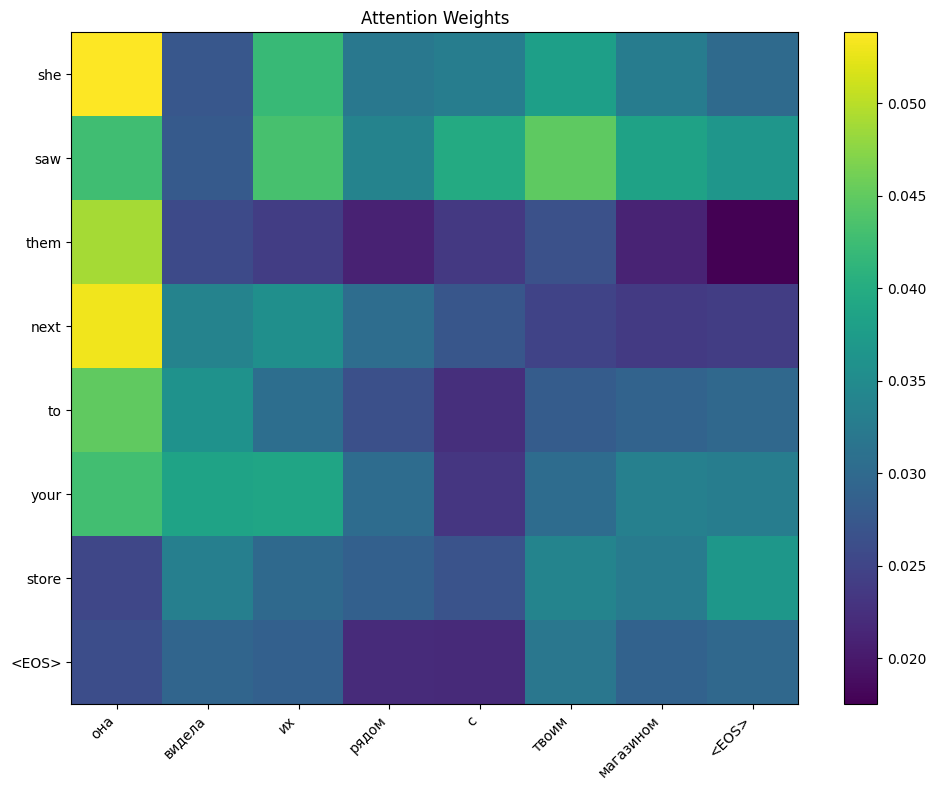

In [121]:
# Тестирование на разных примерах
test_sentences = [
    "она говорит по-китаиски",
    "их разделяет большое расстояние",
    "тебе в эту комнату нельзя",
    "она видела их рядом с твоим магазином"
]

for i, sentence in enumerate(test_sentences):
    evaluateAndShowAttention(sentence, head_num=i%4)  # Циклически перебираем головы

После оптимизации качество обучения незначительно улучшилось. Предсказанный перевод полностью совпадает со словарным

## Обучите seq2seq with attention на основе MLP. Оцените качество

In [122]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [123]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = s.lower()
    s = re.sub('[.!?]','',s)
#    s = re.sub(r"([.!?])", r" \1", s)
#    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [124]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')
    lines = [i.split('\tCC-BY', 1)[0] for i in lines]

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [75]:
MAX_LENGTH = 30

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [76]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'rus', True)
print(random.choice(pairs))

Reading lines...
Read 519900 sentence pairs
Trimmed to 5319 sentence pairs
Counting words...
Counted words:
rus 4890
eng 2475
['он простои человек', 'he is a simple man']


The Encoder
-----------





In [77]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

The Decoder
-----------




In [78]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, max_length=MAX_LENGTH, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.max_length = max_length
        self.dropout_p = dropout_p

        self.embedding = nn.Embedding(output_size, hidden_size)
        # MLP слой для внимания (вход: hidden + encoder_output)
        self.attn = nn.Linear(self.hidden_size * 2, 1)  # MLP слой. Вычисляет один score для каждого encoder output
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        # Calculate attention weights using MLP
        attn_energies = torch.zeros(encoder_outputs.size(0)).to(device)  # [max_length]

        for i in range(encoder_outputs.size(0)):
            # Объединяем скрытое состояние и текущий encoder_output
            combined = torch.cat((hidden[0], encoder_outputs[i].unsqueeze(0)), 1)
            # Применяем MLP для получения энергии внимания
            attn_energies[i] = self.attn(combined).squeeze()

        attn_weights = F.softmax(attn_energies, dim=0).unsqueeze(0)  # [1, max_length]

        # Apply attention to encoder outputs
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights.squeeze(0)

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [79]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [80]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder,
          encoder_optimizer, decoder_optimizer, criterion,
          max_length=MAX_LENGTH, just_loss=False):
    """
    just_loss: Если True, только вычисляет loss без обновления весов
    """
    encoder_hidden = encoder.initHidden()

    if not just_loss:
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    loss = 0

    # Прямой проход через encoder
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    # Прямой проход через decoder
    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    for di in range(target_length):
        decoder_output, decoder_hidden, _ = decoder(
            decoder_input, decoder_hidden, encoder_outputs)

        loss += criterion(decoder_output, target_tensor[di])

        if use_teacher_forcing:
            decoder_input = target_tensor[di]
        else:
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()
            if decoder_input.item() == EOS_token:
                break

    if not just_loss:
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()

    return loss.item() / target_length

In [81]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [82]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [83]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [84]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] = encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length, device=device)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)

            # Store attention weights (only for the actual input length)
            if di < max_length and decoder_attention.size(0) == max_length:
                decoder_attentions[di] = decoder_attention

            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1, :input_length]

In [85]:
# добавим функцию для расчета BLEU
def calculate_bleu(encoder, decoder, pairs, n=100):
    references = []
    hypotheses = []
    smoothie = SmoothingFunction().method4

    for i in range(min(n, len(pairs))):
        pair = random.choice(pairs)
        input_sentence = pair[0]
        target_sentence = pair[1]

        # Получаем предсказание модели
        output_words, _ = evaluate(encoder, decoder, input_sentence)
        output_sentence = ' '.join(output_words[:-1])  # Убираем <EOS>

        # Токенизируем предложения
        ref_tokens = target_sentence.split()
        hyp_tokens = output_sentence.split()

        references.append([ref_tokens])
        hypotheses.append(hyp_tokens)

    # Вычисляем BLEU-1, BLEU-2, BLEU-3, BLEU-4
    bleu1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0), smoothing_function=smoothie) # Учитывает только точность отдельных слов (1-граммы)
    bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie) # Учитывает пары последовательных слов
    bleu3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie) # Учитывает тройки последовательных слов
    bleu4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie) # Учитывает четверки последовательных слов

    return bleu1, bleu2, bleu3, bleu4

In [86]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [87]:
hidden_size = 256
encoder3 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder3 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder3, attn_decoder3, 75000, print_every=5000)

8m 38s (- 120m 54s) (5000 6%) 3.2362
17m 41s (- 114m 59s) (10000 13%) 2.7342
26m 57s (- 107m 48s) (15000 20%) 2.3052
36m 22s (- 100m 2s) (20000 26%) 1.9475
45m 46s (- 91m 33s) (25000 33%) 1.5985
55m 19s (- 82m 59s) (30000 40%) 1.2590
64m 55s (- 74m 12s) (35000 46%) 1.0532
74m 28s (- 65m 9s) (40000 53%) 0.8747
84m 8s (- 56m 5s) (45000 60%) 0.7064
93m 50s (- 46m 55s) (50000 66%) 0.5418
103m 27s (- 37m 37s) (55000 73%) 0.4390
113m 17s (- 28m 19s) (60000 80%) 0.3468
122m 57s (- 18m 55s) (65000 86%) 0.2659
132m 50s (- 9m 29s) (70000 93%) 0.2067
142m 35s (- 0m 0s) (75000 100%) 0.1627


In [88]:
bleu1, bleu2, bleu3, bleu4 = calculate_bleu(encoder3, attn_decoder3, pairs, n=500)
print(f"BLEU-1: {bleu1:.4f}")
print(f"BLEU-2: {bleu2:.4f}")
print(f"BLEU-3: {bleu3:.4f}")
print(f"BLEU-4: {bleu4:.4f}")

BLEU-1: 0.9764
BLEU-2: 0.9658
BLEU-3: 0.9564
BLEU-4: 0.9382


In [89]:
evaluateRandomly(encoder3, attn_decoder3)

> она может разговаривать на десяти языках
= she is able to speak ten languages
< she is able to speak ten languages <EOS>

> вы двуличны
= you are two-faced
< you are two-faced <EOS>

> я сеичас готовлю еду
= i am cooking now
< i am cooking now <EOS>

> вы гении
= you are a genius
< you are a genius <EOS>

> я ваша рабыня
= i am your slave
< i am your slave <EOS>

> она стояла на голове
= she stood on her head
< she stood on her head <EOS>

> вы не приглашены
= you aren't invited
< you aren't invited <EOS>

> он вылитыи отец
= he is the spitting image of his father
< he is the spitting image of his father <EOS>

> мы все еще цепляемся за мечты своеи молодости
= we are still clinging to the dreams of our youth
< we are still clinging to the dreams of our youth <EOS>

> она сказала, что это могло бы быть правдои
= she said that it might be true
< she said that it might be true <EOS>



<Figure size 640x480 with 0 Axes>

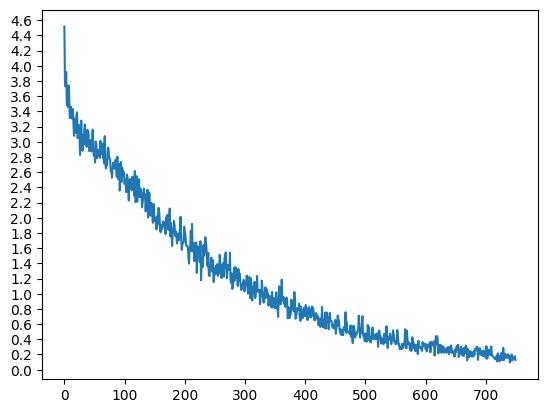

<Figure size 640x480 with 0 Axes>

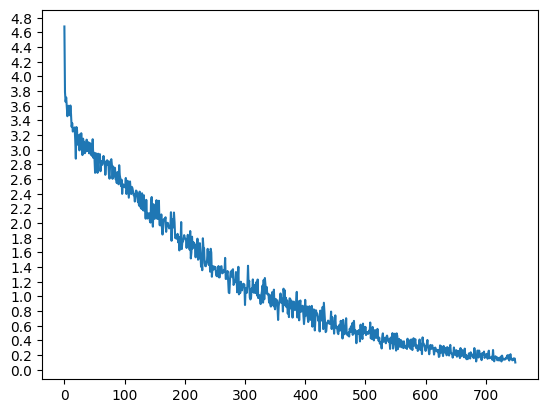

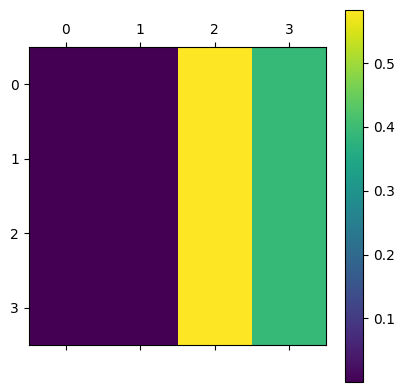

In [90]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Визуализация внимания
output_words, attentions = evaluate(
    encoder3, attn_decoder3, "она говорит по-китаиски")

# Отображение матрицы внимания
plt.matshow(attentions.numpy())
plt.colorbar()
plt.show()

input = она говорит по-китаиски
output = she speaks chinese <EOS>


/tmp/ipython-input-91-3760407091.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipython-input-91-3760407091.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


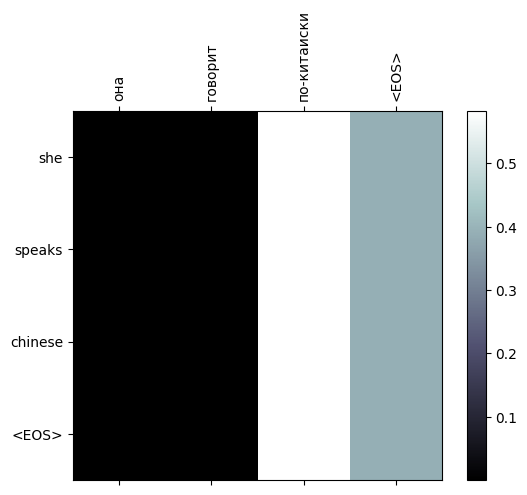

input = их разделяет большое расстояние
output = they are separated by a great distance <EOS>


/tmp/ipython-input-91-3760407091.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipython-input-91-3760407091.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


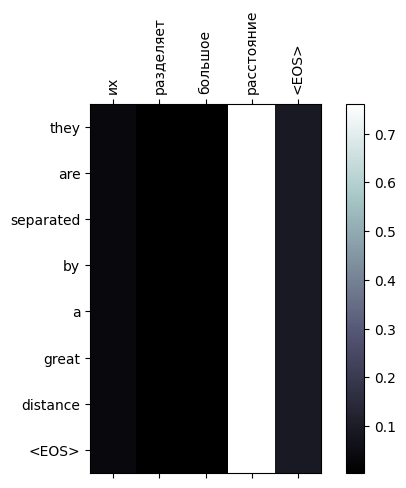

/tmp/ipython-input-91-3760407091.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +


input = тебе в эту комнату нельзя
output = you aren't allowed in this into that room <EOS>


/tmp/ipython-input-91-3760407091.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


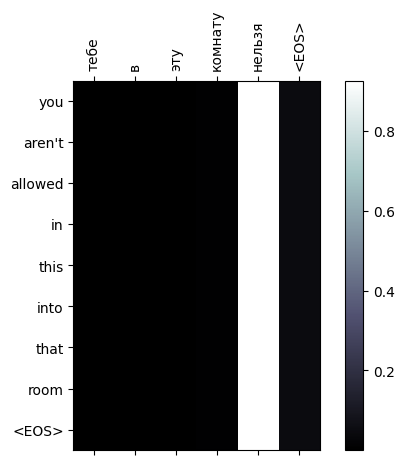

input = она видела их рядом с твоим магазином
output = she saw them next to your store <EOS>


/tmp/ipython-input-91-3760407091.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipython-input-91-3760407091.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


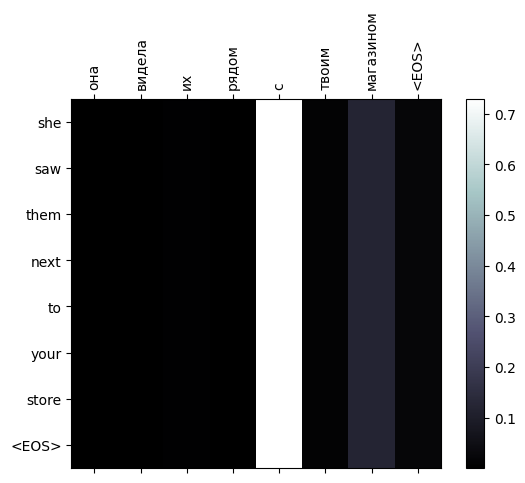

In [91]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder3, attn_decoder3, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("она говорит по-китаиски")

evaluateAndShowAttention("их разделяет большое расстояние")

evaluateAndShowAttention("тебе в эту комнату нельзя")

evaluateAndShowAttention("она видела их рядом с твоим магазином")

Качество обучения показывает хорошие значения и предсказанный перевод полностью совпадает со словарным

## Сравнение моделей

In [125]:
# создадим функцию для оценки всех метрик
def evaluate_model(encoder, decoder, model_name, pairs, n_eval=100):
    # Оценка BLEU
    bleu1, bleu2, bleu3, bleu4 = calculate_bleu(encoder, decoder, pairs, n_eval)

    # Оценка точности (accuracy)
    correct = 0
    for _ in range(n_eval):
        pair = random.choice(pairs)
        output_words, _ = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words[:-1])  # Убираем <EOS>
        if output_sentence.lower() == pair[1].lower():
            correct += 1
    accuracy = correct / n_eval

    # Оценка perplexity (на основе loss)
    losses = []
    # Создаем временные оптимизаторы
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=0.01)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=0.01)

    for _ in range(min(100, len(pairs))):
        pair = random.choice(pairs)
        input_tensor = tensorFromSentence(input_lang, pair[0])
        target_tensor = tensorFromSentence(output_lang, pair[1])
        loss = train(input_tensor, target_tensor, encoder, decoder,
                    encoder_optimizer, decoder_optimizer, nn.NLLLoss(),
                    just_loss=True)
        losses.append(loss)

    perplexity = np.exp(np.mean(losses))

    return {
        'Model': model_name,
        'BLEU-1': bleu1,
        'BLEU-2': bleu2,
        'BLEU-3': bleu3,
        'BLEU-4': bleu4,
        'Accuracy': accuracy,
        'Perplexity': perplexity
    }

In [93]:
# Список моделей для сравнения
models = [
    (encoder1, attn_decoder1, "Basic attention Seq2Seq"),
    (encoder3, attn_decoder3, "MLP Attention")
]

# Создаем DataFrame для результатов
results = []

for encoder, decoder, name in models:
    print(f"Evaluating {name}...")
    model_results = evaluate_model(encoder, decoder, name, pairs, n_eval=200)
    results.append(model_results)

df_results = pd.DataFrame(results)

Evaluating Basic attention Seq2Seq...
Evaluating MLP Attention...


In [126]:
# Список моделей для сравнения
models = [
    (encoder1, attn_decoder1, "Basic attention Seq2Seq"),
    (encoder2, attn_decoder2, "Multi-Head Attention"),
    (encoder3, attn_decoder3, "MLP Attention")
]

# Создаем DataFrame для результатов
results = []

for encoder, decoder, name in models:
    print(f"Evaluating {name}...")
    model_results = evaluate_model(encoder, decoder, name, pairs, n_eval=200)
    results.append(model_results)

df_results = pd.DataFrame(results)

Evaluating Basic attention Seq2Seq...
Evaluating Multi-Head Attention...
Evaluating MLP Attention...


In [127]:
model_results = evaluate_model(encoder, decoder, name, pairs, n_eval=200)

In [128]:
# Красивое отображение результатов
display(df_results.style
        .background_gradient(cmap='Blues', subset=['BLEU-4', 'Accuracy'])
        .background_gradient(cmap='Reds_r', subset=['Perplexity'])
        .format({
            'BLEU-1': '{:.3f}',
            'BLEU-2': '{:.3f}',
            'BLEU-3': '{:.3f}',
            'BLEU-4': '{:.3f}',
            'Accuracy': '{:.2%}',
            'Perplexity': '{:.1f}'
        }))

,Model,BLEU-1,BLEU-2,BLEU-3,BLEU-4,Accuracy,Perplexity
0,Basic attention Seq2Seq,0.957,0.944,0.933,0.916,90.00%,1.1
1,Multi-Head Attention,0.981,0.973,0.966,0.952,91.00%,1.1
2,MLP Attention,0.980,0.972,0.963,0.947,92.50%,1.1


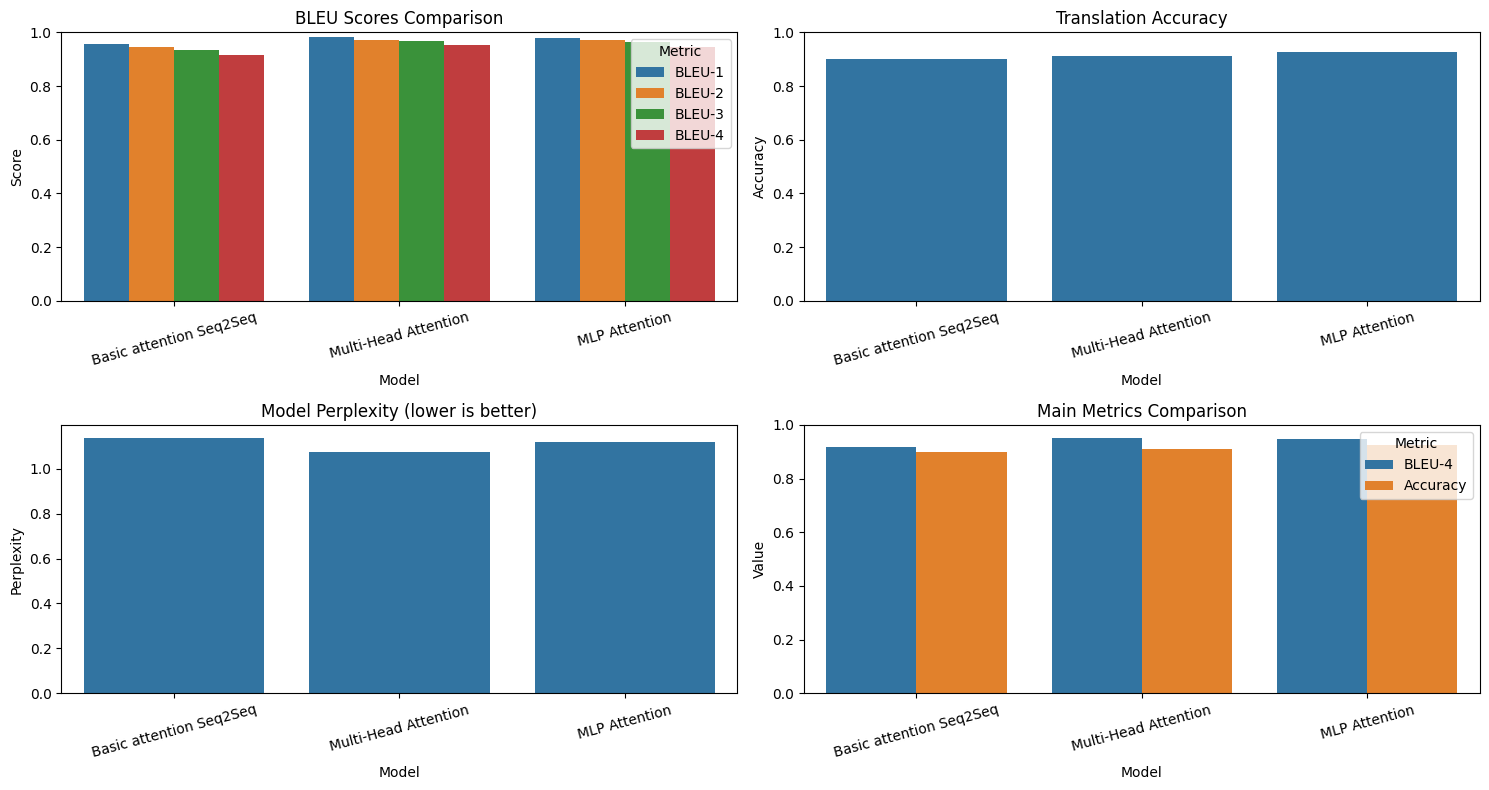

In [129]:
# визуализация метрик
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 8))

# График BLEU scores
plt.subplot(2, 2, 1)
df_bleu = df_results.melt(id_vars='Model',
                         value_vars=['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4'],
                         var_name='Metric', value_name='Score')
sns.barplot(x='Model', y='Score', hue='Metric', data=df_bleu)
plt.title('BLEU Scores Comparison')
plt.ylim(0, 1)
plt.xticks(rotation=15)

# График Accuracy
plt.subplot(2, 2, 2)
sns.barplot(x='Model', y='Accuracy', data=df_results)
plt.title('Translation Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=15)

# График Perplexity
plt.subplot(2, 2, 3)
sns.barplot(x='Model', y='Perplexity', data=df_results)
plt.title('Model Perplexity (lower is better)')
plt.xticks(rotation=15)

# Комбинированный график
plt.subplot(2, 2, 4)
df_melt = df_results.melt(id_vars='Model',
                         value_vars=['BLEU-4', 'Accuracy'],
                         var_name='Metric', value_name='Value')
sns.barplot(x='Model', y='Value', hue='Metric', data=df_melt)
plt.title('Main Metrics Comparison')
plt.ylim(0, 1)
plt.xticks(rotation=15)

plt.tight_layout()
plt.show()

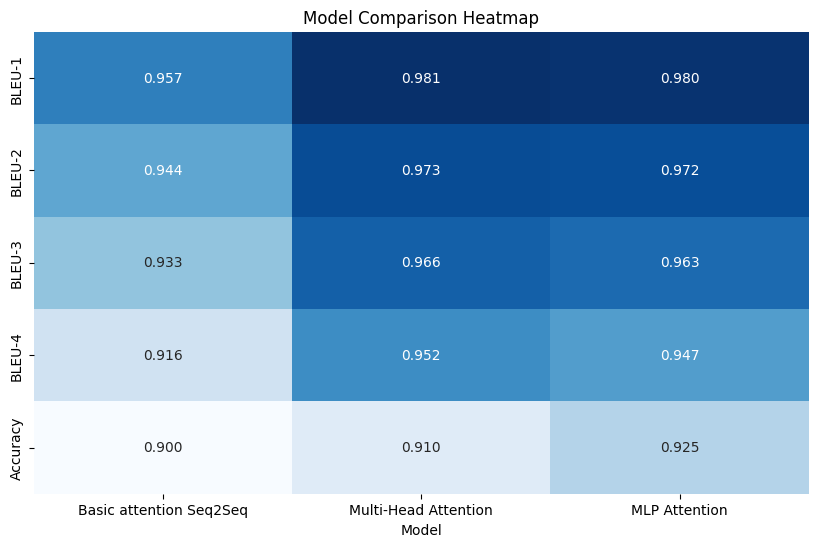

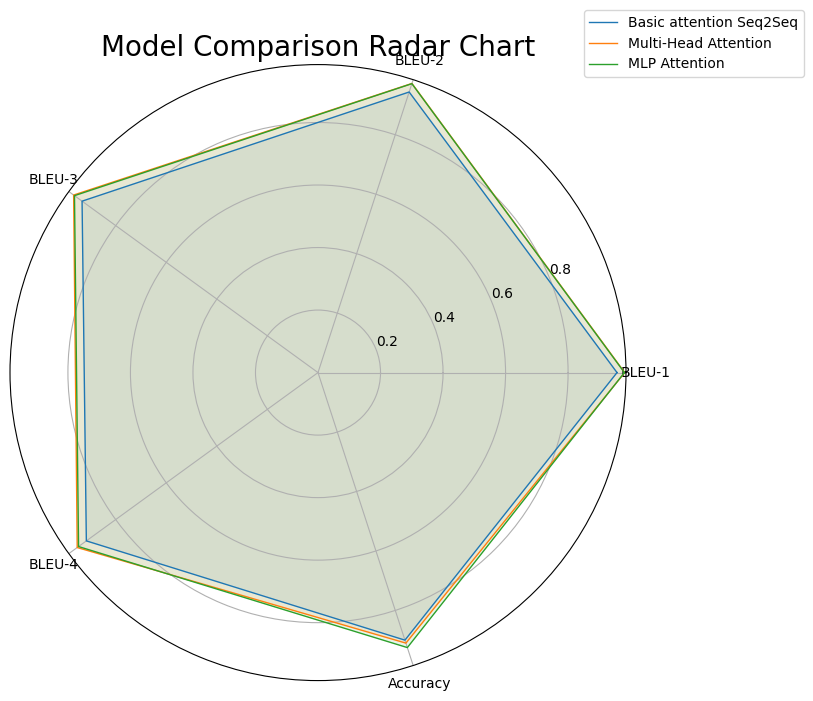

In [130]:
# Heatmap для всех метрик
plt.figure(figsize=(10, 6))
metrics = df_results.set_index('Model').drop('Perplexity', axis=1)
sns.heatmap(metrics.T, annot=True, fmt='.3f', cmap='Blues', cbar=False)
plt.title('Model Comparison Heatmap')
plt.show()

# Radar chart для комплексного сравнения
from math import pi
categories = ['BLEU-1','BLEU-2','BLEU-3','BLEU-4','Accuracy']

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

for idx, row in df_results.iterrows():
    values = row[categories].values.flatten().tolist()
    values += values[:1]  # Замыкаем график

    angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
    angles += angles[:1]

    ax.plot(angles, values, linewidth=1, linestyle='solid', label=row['Model'])
    ax.fill(angles, values, alpha=0.1)

plt.title('Model Comparison Radar Chart', size=20)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
plt.show()

## Выводы

1. В работе решена задача перевода с помощью механизма внимания тремя способами:

a) на основе скалярного произведения

b) на основе скалярного произведения с добавлением Multi-head attention

c) на основе MLP

2. Качество модели и предсказанный перевод по всем моделям примерно на одном уровне
3. Все модели могут быть использованы в дальнейшем для работы